<a href="https://colab.research.google.com/github/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/9_interpreting_rnn_models_using_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting RNN Models using Lime

Consider a scenario where we developed a classifier that identifies abusive comments on a discussion forum website. The classifier identifies comments that are objectionable/abusive and performs the job of a human moderator by either deleting them or making them invisible to users. We know that classifiers aren’t perfect and can make errors. 

**What if the commenter questions this moderation decision and asks for an
explanation?**

Some method to “explain” the classification decision by pointing to which feature’s presence prompted such a decision can be useful in such cases. Such a
method is also useful to provide some insights into the model and how it may perform on real-world data (instead of train/test sets), which may result in better, more reliable models in the future.

[Lime](https://github.com/marcotcr/lime) is one such tool that attempts to interpret a black-box classification model by approximating it with a linear model locally around a given training instance. The advantage of this is that such a linear model is expressed as a weighted sum of its features and is easy to interpret for humans. For example, if there are two features, `f1` and `f2`, for a given test instance of a binary classifier with classes A and B, a Lime linear model around this instance could be something like `-0.3 × f1 + 0.4 × f2` with a prediction B. This indicates that the presence of feature f1 will negatively affect this prediction (by 0.3) and skew it toward A.

Let’s now look at how [Lime](https://github.com/marcotcr/lime) can be used to understand the predictions of a text classifier.

## Setup

In this notebook we will demonstrate how to interpret a Deep Learning Model using [LIME](https://github.com/marcotcr/lime)(local interpretable model-agnostic explanations), a python package for explaining machine learning classifiers. 

In [ ]:
%%shell

pip install lime

In [17]:
import tensorflow as tf
from tensorflow import keras

import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

import pandas as pd #to work with csv files

#pre-processing of text
import string
import re
import os


import warnings
warnings.filterwarnings("ignore")

## Part 1: Training and evaluating LSTM text classifier

We will be building an LSTM model with an embedding layer trained on the fly. We will be following all the preprocessing steps as in the [Deep Learning for Text Classification](https://github.com/rahiakela/practical-natural-language-processing/blob/chapter-4-text-classification/5_deep_learning_for_text_classification.ipynb) notebook in this repo.


In [4]:
#helper functions to lead the data
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train,test = download_and_load_datasets()

In [5]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [6]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [7]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
# test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0} 

In [8]:
test.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [9]:
test_labels = test['polarity'].values
test_labels

array([0, 0, 0, ..., 1, 1, 1])

We need to design an sklearn pipeline with our model.
What is a pipeline?<br>

**Transformer** in scikit-learn - some class that have fit and transform method, or fit_transform method.

**Predictor** - some class that has fit and predict methods, or fit_predict method.

**Pipeline** is just an abstract notion, it's not some existing ml algorithm. Often in ML tasks you need to perform sequence of different transformations (find set of features, generate new features, select only some good features) of raw dataset before applying final estimator. Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator. It encapsulates transformers and predictors inside

In [10]:
class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

In [11]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

We will only train for 2 epochs. A better model could be trained with more epochs and early stopping.

In [12]:
batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""
    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

Epoch 1/2
782/782 [==============================] - 2285s 3s/step - loss: 0.4317 - accuracy: 0.8059
Epoch 2/2
782/782 [==============================] - 2303s 3s/step - loss: 0.2309 - accuracy: 0.9129


## Part 2: Explaining Classifier Predictions with Lime

Let’s take a model we already built and see how Lime can help us interpret its predictions.

In [22]:
# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])

Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
I agree with the posters before that the characters were exceptionally strong and believable and all the actors at their top form. I especially loved David Boreanaz stretching in a part so unlike anything else he played proving once again his amazing gift for comedy. The first part of the movie was light and funny, the blackmail part was a bit surrealistic but interesting - and it was all downhill from there.<br /><br />I found it frustrating that at least two out of the 3 girls (Keira and Lisa) get out of the blackmail&betrayal scot free, nary a trace left on their psyche. I know the movie amended the darker ending of the play - and I am not saying I missed the murder part. But I surely needed to see those two getting their comeuppance somehow and I was left groaning in frustration with the ending. (It's why I gave it only a 9)<br /><br />But definitely an interesting film.
----

157/157 [==============================] - 46s 296ms/step


Text(0.5, 1.0, 'Sample 11 features weights given by LIME')

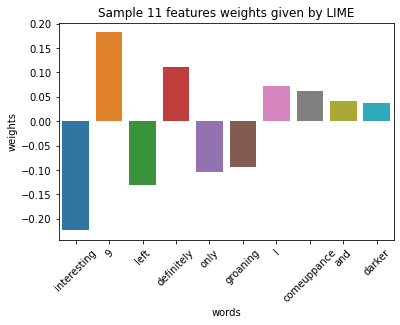

In [23]:
explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights)
plt.xticks(rotation=45)
plt.title("Sample {} features weights given by LIME".format(idx))

We have used the LIME interpretation to provide explanations for a recurrent neural network. Looking at the graph we understand that the sentence is negative and the word "worst" affects it the most.